# Value Iteration and Multi-Agent Simulation

<>:127: SyntaxWarning: invalid escape sequence '\p'
<>:127: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_20764/834299316.py:127: SyntaxWarning: invalid escape sequence '\p'
  self._prepare_plot("Optimal Policy ($\pi^*$)")


Value Iteration Converged!
Optimal Policy Extracted.


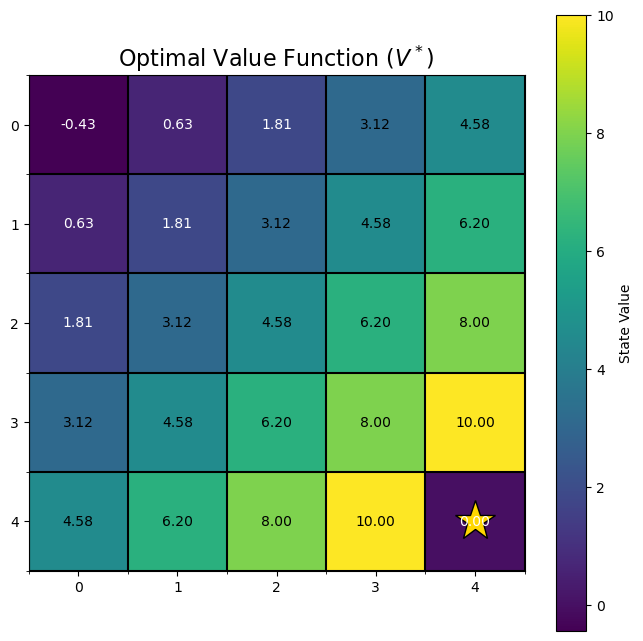

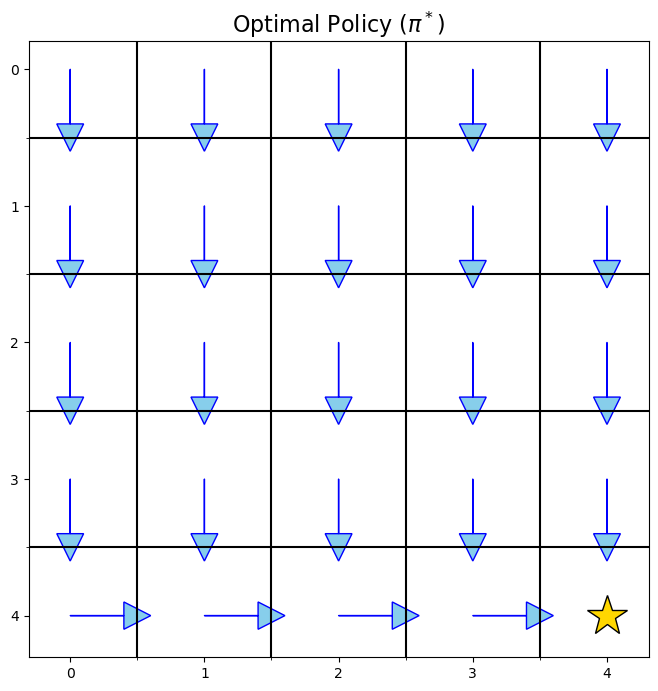


--- Simulating 10 Agents Following Optimal Policy ---
Agent 1 path: [(0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4)]
Agent 2 path: [(1, 3), (2, 3), (3, 3), (4, 3), (4, 4)]
Agent 3 path: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4)]
Agent 4 path: [(2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4)]
Agent 5 path: [(3, 4), (4, 4)]
Agent 6 path: [(2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4)]
Agent 7 path: [(3, 4), (4, 4)]
Agent 8 path: [(1, 2), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)]
Agent 9 path: [(0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
Agent 10 path: [(1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


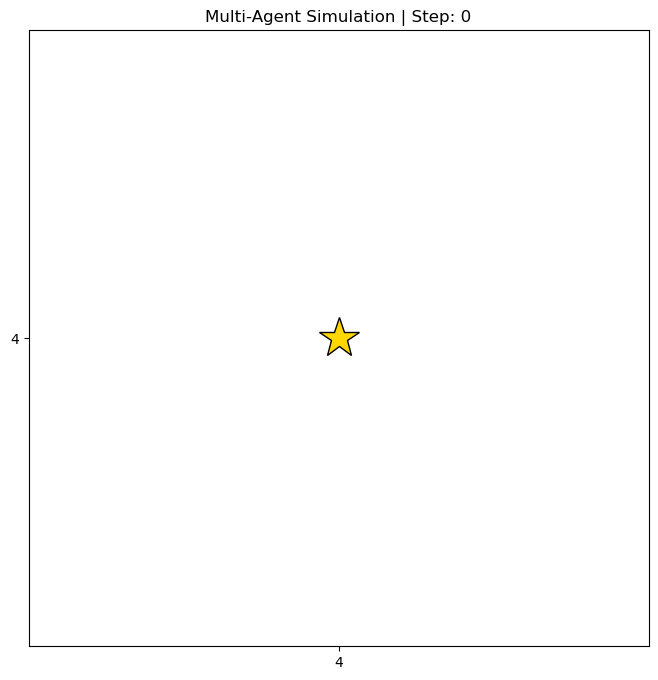

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from typing import Tuple, List

# --- Environment Class (Unchanged) ---
class GridWorld:
    """Represents a 5x5 Grid World environment."""
    def __init__(self, size: Tuple[int, int] = (5, 5), terminal_state: Tuple[int, int] = (4, 4)):
        self.rows, self.cols = size
        self.terminal_state = terminal_state
        self.states = [(r, c) for r in range(self.rows) for c in range(self.cols)]
        self.actions = [0, 1, 2, 3] # 0:Up, 1:Down, 2:Left, 3:Right
        self.action_delta = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def get_transition_prob(self, state: Tuple[int, int], action: int) -> Tuple[Tuple[int, int], float]:
        """Gets the next state and its probability (here, deterministic)."""
        if self.is_terminal(state):
            return state, 1.0

        row, col = state
        d_row, d_col = self.action_delta[action]
        next_row, next_col = row + d_row, col + d_col

        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = row, col
        
        return (next_row, next_col), 1.0

    def get_reward(self, state: Tuple[int, int]) -> int:
        """Returns the reward for a given state."""
        return 10 if state == self.terminal_state else -1

    def is_terminal(self, state: Tuple[int, int]) -> bool:
        """Checks if a state is the terminal state."""
        return state == self.terminal_state

# --- New Value Iteration Solver Class ---
class ValueIterationSolver:
    """
    Solves the GridWorld environment by finding the optimal value function and policy.
    """
    def __init__(self, env: GridWorld, gamma: float = 0.9):
        self.env = env
        self.gamma = gamma
        self.value_table = np.zeros((env.rows, env.cols))

    def iterate(self, theta: float = 1e-6):
        """
        Performs the Value Iteration algorithm.
        
        It repeatedly sweeps through all states, updating their value based on the
        best possible action, until the value function converges.
        """
        delta = float('inf')
        while delta > theta:
            delta = 0
            for state in self.env.states:
                if self.env.is_terminal(state):
                    continue
                
                old_value = self.value_table[state]
                action_values = []
                for action in self.env.actions:
                    next_state, _ = self.env.get_transition_prob(state, action)
                    reward = self.env.get_reward(next_state)
                    action_values.append(reward + self.gamma * self.value_table[next_state])
                
                self.value_table[state] = max(action_values)
                delta = max(delta, abs(old_value - self.value_table[state]))
        print("Value Iteration Converged!")

    def get_policy(self) -> np.ndarray:
        """
        Extracts the optimal policy from the converged value function.
        
        For each state, it finds the action that leads to the state with the highest value.
        """
        policy = np.zeros((self.env.rows, self.env.cols), dtype=int)
        for state in self.env.states:
            if self.env.is_terminal(state):
                continue
            
            action_values = []
            for action in self.env.actions:
                next_state, _ = self.env.get_transition_prob(state, action)
                reward = self.env.get_reward(next_state)
                action_values.append(reward + self.gamma * self.value_table[next_state])
            
            policy[state] = np.argmax(action_values)
        print("Optimal Policy Extracted.")
        return policy

# --- Updated Visualizer for Results and Multi-Agent Animation ---
class GridVisualizer:
    """Handles visualization of the value function, policy, and agent animations."""
    def __init__(self, env: GridWorld):
        self.env = env
        self.fig, self.ax = None, None
    
    def _prepare_plot(self, title: str):
        """Helper to create a standard grid plot."""
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_title(title, fontsize=16)
        self.ax.set_xticks(np.arange(0, self.env.cols, 1))
        self.ax.set_yticks(np.arange(0, self.env.rows, 1))
        self.ax.set_xticks(np.arange(-.5, self.env.cols, 1), minor=True)
        self.ax.set_yticks(np.arange(-.5, self.env.rows, 1), minor=True)
        self.ax.grid(which="minor", color="black", linestyle='-', linewidth=1.5)
        self.ax.invert_yaxis()
        # Mark terminal state
        self.ax.plot(self.env.terminal_state[1], self.env.terminal_state[0], '*', color='gold', markersize=30, markeredgecolor='black')

    def plot_value_table(self, value_table: np.ndarray):
        """Visualizes the value function as a heatmap."""
        self._prepare_plot("Optimal Value Function ($V^*$)")
        im = self.ax.imshow(value_table, cmap='viridis')
        self.fig.colorbar(im, ax=self.ax, label="State Value")
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                self.ax.text(c, r, f"{value_table[r, c]:.2f}", ha='center', va='center', color='white' if value_table[r, c] < 2 else 'black')
        plt.show()

    def plot_policy(self, policy: np.ndarray):
        """Visualizes the policy with arrows."""
        self._prepare_plot("Optimal Policy ($\pi^*$)")
        # Define arrows for actions: U, V components of vectors
        action_arrows = {0: (0, -0.4), 1: (0, 0.4), 2: (-0.4, 0), 3: (0.4, 0)} # Up, Down, Left, Right
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                if not self.env.is_terminal((r, c)):
                    action = policy[r, c]
                    dx, dy = action_arrows[action]
                    self.ax.arrow(c, r, dx, dy, head_width=0.2, head_length=0.2, fc='skyblue', ec='blue')
        plt.show()
    
    def animate_episodes(self, paths: List[List[Tuple[int, int]]]):
        """Animates multiple agents following their paths."""
        self._prepare_plot(f"Multi-Agent Simulation ({len(paths)} Agents)")
        
        # Generate distinct colors for each agent
        colors = plt.cm.jet(np.linspace(0, 1, len(paths)))
        agent_markers = [self.ax.plot([], [], 'o', color=colors[i], markersize=12)[0] for i in range(len(paths))]
        
        max_path_len = max(len(p) for p in paths)

        def update(frame):
            for i, marker in enumerate(agent_markers):
                if frame < len(paths[i]):
                    pos = paths[i][frame]
                    marker.set_data([pos[1]], [pos[0]])
                else: # Agent has finished
                    pos = paths[i][-1]
                    marker.set_data([pos[1]], [pos[0]])
            self.ax.set_title(f"Multi-Agent Simulation | Step: {frame}")
            return agent_markers

        anim = animation.FuncAnimation(self.fig, update, frames=max_path_len, interval=150, blit=True, repeat=False)
        plt.show()

# --- Main Simulation Block ---
if __name__ == "__main__":
    # --- 1. Learning Phase ---
    env = GridWorld()
    solver = ValueIterationSolver(env, gamma=0.9)
    solver.iterate()
    
    value_table = solver.value_table
    optimal_policy = solver.get_policy()

    # --- 2. Visualization of Learning Results ---
    visualizer = GridVisualizer(env)
    visualizer.plot_value_table(value_table)
    visualizer.plot_policy(optimal_policy)

    # --- 3. Execution Phase: Simulate Multiple Agents ---
    NUM_AGENTS = 10
    agent_starts = [(np.random.randint(env.rows), np.random.randint(env.cols)) for _ in range(NUM_AGENTS)]
    all_paths = []

    print(f"\n--- Simulating {NUM_AGENTS} Agents Following Optimal Policy ---")
    for i, start_pos in enumerate(agent_starts):
        path = [start_pos]
        current_state = start_pos
        
        # Simulate one agent's journey
        while not env.is_terminal(current_state):
            action = optimal_policy[current_state]
            # Use env.get_transition_prob to find next state deterministically
            next_state, _ = env.get_transition_prob(current_state, action)
            path.append(next_state)
            current_state = next_state
        
        all_paths.append(path)
        print(f"Agent {i+1} path: {path}")
    
    # Animate all agents moving together
    visualizer.animate_episodes(all_paths)

# Policy Iteration

<>:148: SyntaxWarning: invalid escape sequence '\p'
<>:148: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_20764/3401439470.py:148: SyntaxWarning: invalid escape sequence '\p'
  self._prepare_plot("Optimal Policy ($\pi^*$)")


--- Iteration 1 ---
Policy Evaluation complete.
Policy Improvement complete. Policy has changed.
--- Iteration 2 ---
Policy Evaluation complete.
Policy Improvement complete. Policy has changed.
--- Iteration 3 ---
Policy Evaluation complete.
Policy Improvement complete. Policy has changed.
--- Iteration 4 ---
Policy Evaluation complete.
Policy Improvement complete. Policy has changed.
--- Iteration 5 ---
Policy Evaluation complete.
Policy Improvement complete. Policy has changed.
--- Iteration 6 ---
Policy Evaluation complete.
Policy has stabilized. Convergence reached!


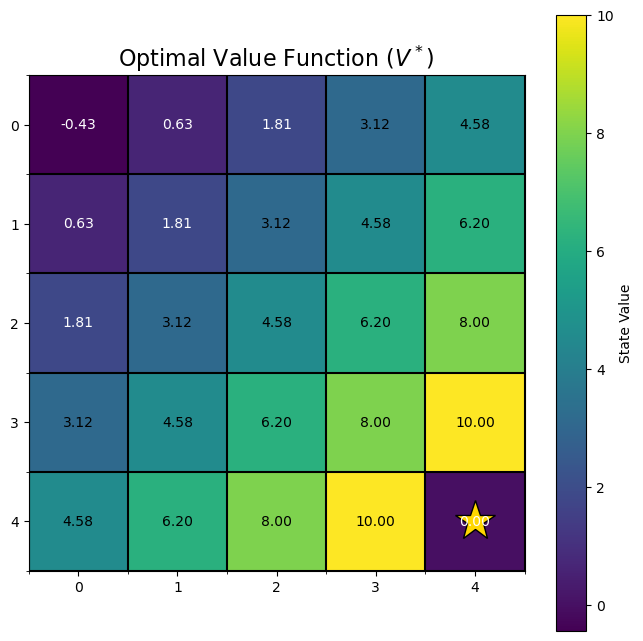

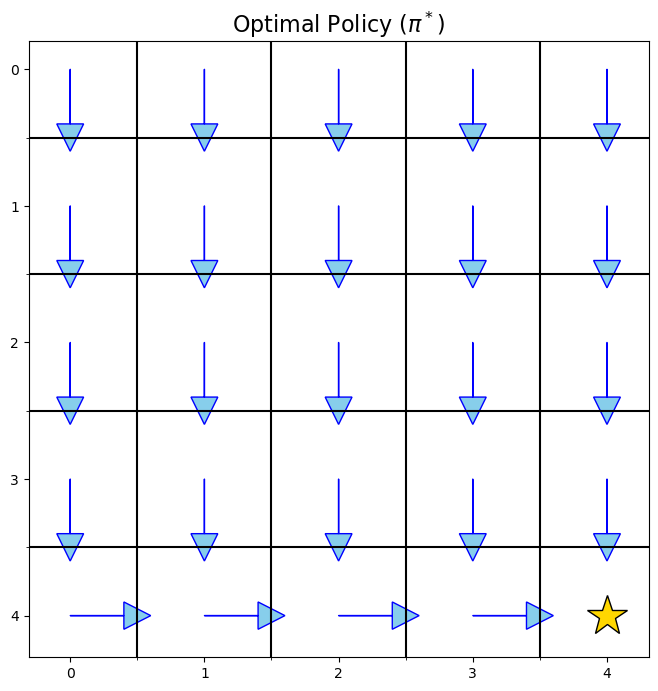


--- Simulating 10 Agents Following Optimal Policy ---
Agent 1 path length: 4
Agent 2 path length: 4
Agent 3 path length: 5
Agent 4 path length: 3
Agent 5 path length: 5
Agent 6 path length: 7
Agent 7 path length: 2
Agent 8 path length: 3
Agent 9 path length: 4
Agent 10 path length: 4


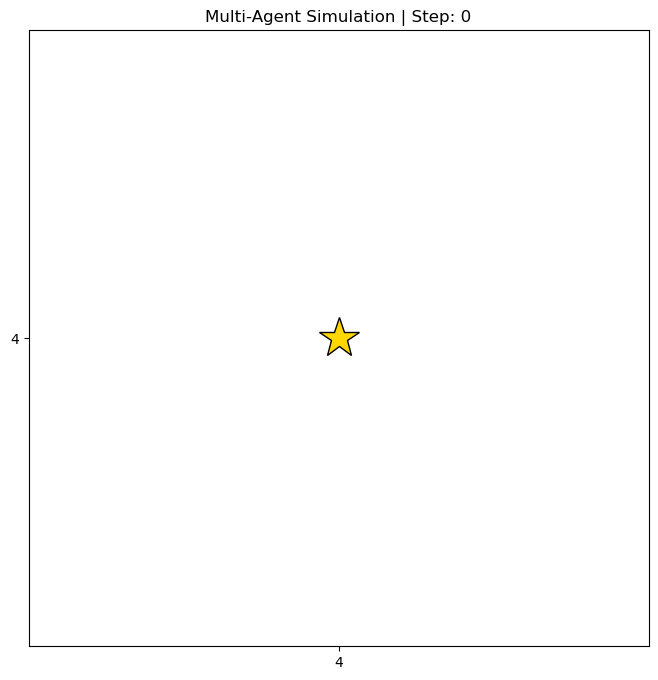

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from typing import Tuple, List

# --- Environment Class (Unchanged) ---
class GridWorld:
    """Represents a 5x5 Grid World environment."""
    def __init__(self, size: Tuple[int, int] = (5, 5), terminal_state: Tuple[int, int] = (4, 4)):
        self.rows, self.cols = size
        self.terminal_state = terminal_state
        self.states = [(r, c) for r in range(self.rows) for c in range(self.cols)]
        self.actions = [0, 1, 2, 3] # 0:Up, 1:Down, 2:Left, 3:Right
        self.action_delta = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def get_transition_prob(self, state: Tuple[int, int], action: int) -> Tuple[Tuple[int, int], float]:
        """Gets the next state and its probability (here, deterministic)."""
        if self.is_terminal(state):
            return state, 1.0

        row, col = state
        d_row, d_col = self.action_delta[action]
        next_row, next_col = row + d_row, col + d_col

        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = row, col
        
        return (next_row, next_col), 1.0

    def get_reward(self, state: Tuple[int, int]) -> int:
        """Returns the reward for a given state."""
        return 10 if state == self.terminal_state else -1

    def is_terminal(self, state: Tuple[int, int]) -> bool:
        """Checks if a state is the terminal state."""
        return state == self.terminal_state

# --- New Policy Iteration Solver Class ---
class PolicyIterationSolver:
    """
    Solves the GridWorld environment using the Policy Iteration algorithm.
    """
    def __init__(self, env: GridWorld, gamma: float = 0.9):
        self.env = env
        self.gamma = gamma
        # 1. Initialize a random policy and a zero value table
        self.policy_table = np.random.randint(0, 4, size=(env.rows, env.cols))
        self.value_table = np.zeros((env.rows, env.cols))

    def _policy_evaluation(self, theta: float = 1e-6):
        """
        Calculates the value function for the current policy.
        This is done by repeatedly applying the Bellman expectation equation until convergence.
        """
        delta = float('inf')
        while delta > theta:
            delta = 0
            for state in self.env.states:
                if self.env.is_terminal(state):
                    continue
                
                old_value = self.value_table[state]
                action = self.policy_table[state] # Follow the current policy
                
                next_state, _ = self.env.get_transition_prob(state, action)
                reward = self.env.get_reward(next_state)
                
                self.value_table[state] = reward + self.gamma * self.value_table[next_state]
                delta = max(delta, abs(old_value - self.value_table[state]))

    def _policy_improvement(self) -> bool:
        """
        Improves the current policy by acting greedily w.r.t. the value function.
        Returns True if the policy is stable (no changes), False otherwise.
        """
        is_stable = True
        for state in self.env.states:
            if self.env.is_terminal(state):
                continue
                
            old_action = self.policy_table[state]
            
            # Find the best action according to the current value function
            action_values = []
            for action in self.env.actions:
                next_state, _ = self.env.get_transition_prob(state, action)
                reward = self.env.get_reward(next_state)
                action_values.append(reward + self.gamma * self.value_table[next_state])
            
            self.policy_table[state] = np.argmax(action_values)
            
            if old_action != self.policy_table[state]:
                is_stable = False
        return is_stable

    def iterate(self):
        """
        Performs the Policy Iteration algorithm.
        It alternates between evaluation and improvement until the policy stabilizes.
        """
        policy_stable = False
        iteration = 1
        while not policy_stable:
            print(f"--- Iteration {iteration} ---")
            # 2. Policy Evaluation: Update V(s) based on current policy
            self._policy_evaluation()
            print("Policy Evaluation complete.")
            
            # 3. Policy Improvement: Update policy based on new V(s)
            policy_stable = self._policy_improvement()
            if policy_stable:
                print("Policy has stabilized. Convergence reached!")
            else:
                print("Policy Improvement complete. Policy has changed.")
            iteration += 1

# --- Visualizer Class (Unchanged from Value Iteration) ---
class GridVisualizer:
    """Handles visualization of the value function, policy, and agent animations."""
    def __init__(self, env: GridWorld):
        self.env = env
        self.fig, self.ax = None, None
    
    def _prepare_plot(self, title: str):
        """Helper to create a standard grid plot."""
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_title(title, fontsize=16)
        self.ax.set_xticks(np.arange(0, self.env.cols, 1))
        self.ax.set_yticks(np.arange(0, self.env.rows, 1))
        self.ax.set_xticks(np.arange(-.5, self.env.cols, 1), minor=True)
        self.ax.set_yticks(np.arange(-.5, self.env.rows, 1), minor=True)
        self.ax.grid(which="minor", color="black", linestyle='-', linewidth=1.5)
        self.ax.invert_yaxis()
        self.ax.plot(self.env.terminal_state[1], self.env.terminal_state[0], '*', color='gold', markersize=30, markeredgecolor='black')

    def plot_value_table(self, value_table: np.ndarray):
        """Visualizes the value function as a heatmap."""
        self._prepare_plot("Optimal Value Function ($V^*$)")
        im = self.ax.imshow(value_table, cmap='viridis')
        self.fig.colorbar(im, ax=self.ax, label="State Value")
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                self.ax.text(c, r, f"{value_table[r, c]:.2f}", ha='center', va='center', color='white' if value_table[r, c] < 2 else 'black')
        plt.show()

    def plot_policy(self, policy: np.ndarray):
        """Visualizes the policy with arrows."""
        self._prepare_plot("Optimal Policy ($\pi^*$)")
        action_arrows = {0: (0, -0.4), 1: (0, 0.4), 2: (-0.4, 0), 3: (0.4, 0)}
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                if not self.env.is_terminal((r, c)):
                    action = policy[r, c]
                    dx, dy = action_arrows[action]
                    self.ax.arrow(c, r, dx, dy, head_width=0.2, head_length=0.2, fc='skyblue', ec='blue')
        plt.show()
    
    def animate_episodes(self, paths: List[List[Tuple[int, int]]]):
        """Animates multiple agents following their paths."""
        self._prepare_plot(f"Multi-Agent Simulation ({len(paths)} Agents)")
        colors = plt.cm.jet(np.linspace(0, 1, len(paths)))
        agent_markers = [self.ax.plot([], [], 'o', color=colors[i], markersize=12)[0] for i in range(len(paths))]
        max_path_len = max(len(p) for p in paths)

        def update(frame):
            for i, marker in enumerate(agent_markers):
                pos_index = min(frame, len(paths[i]) - 1)
                pos = paths[i][pos_index]
                marker.set_data([pos[1]], [pos[0]])
            self.ax.set_title(f"Multi-Agent Simulation | Step: {frame}")
            return agent_markers

        anim = animation.FuncAnimation(self.fig, update, frames=max_path_len, interval=150, blit=True, repeat=False)
        plt.show()

# --- Main Simulation Block ---
if __name__ == "__main__":
    # --- 1. Learning Phase ---
    env = GridWorld()
    solver = PolicyIterationSolver(env, gamma=0.9)
    solver.iterate()
    
    value_table = solver.value_table
    optimal_policy = solver.policy_table

    # --- 2. Visualization of Learning Results ---
    visualizer = GridVisualizer(env)
    visualizer.plot_value_table(value_table)
    visualizer.plot_policy(optimal_policy)

    # --- 3. Execution Phase: Simulate Multiple Agents ---
    NUM_AGENTS = 10
    agent_starts = [(np.random.randint(env.rows), np.random.randint(env.cols)) for _ in range(NUM_AGENTS)]
    all_paths = []

    print(f"\n--- Simulating {NUM_AGENTS} Agents Following Optimal Policy ---")
    for i, start_pos in enumerate(agent_starts):
        path = [start_pos]
        current_state = start_pos
        
        while not env.is_terminal(current_state):
            action = optimal_policy[current_state]
            next_state, _ = env.get_transition_prob(current_state, action)
            path.append(next_state)
            current_state = next_state
        
        all_paths.append(path)
        print(f"Agent {i+1} path length: {len(path)-1}")
    
    # Animate all agents moving together
    visualizer.animate_episodes(all_paths)

# Monte Carlo

<>:139: SyntaxWarning: invalid escape sequence '\p'
<>:139: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_20764/2141383075.py:139: SyntaxWarning: invalid escape sequence '\p'
  self._prepare_plot("Optimal Policy ($\pi^*$)")


Running episode 1000/10000...
Running episode 2000/10000...
Running episode 3000/10000...
Running episode 4000/10000...
Running episode 5000/10000...
Running episode 6000/10000...
Running episode 7000/10000...
Running episode 8000/10000...
Running episode 9000/10000...
Running episode 10000/10000...
Monte Carlo learning complete!


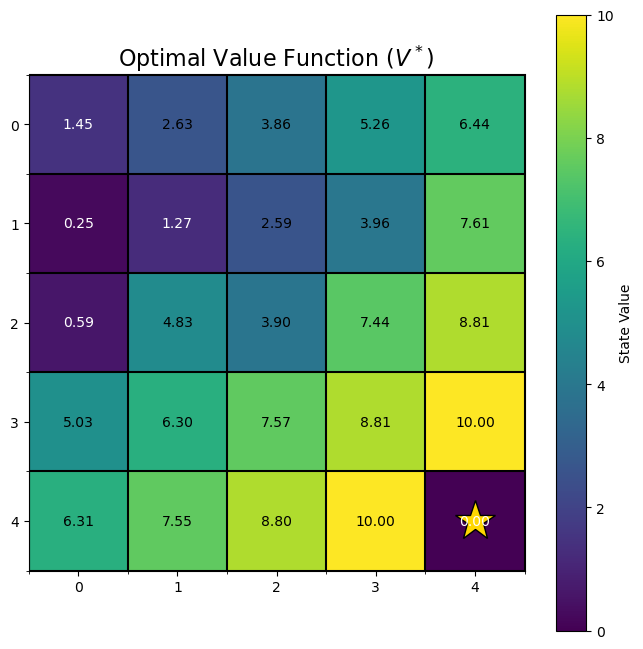

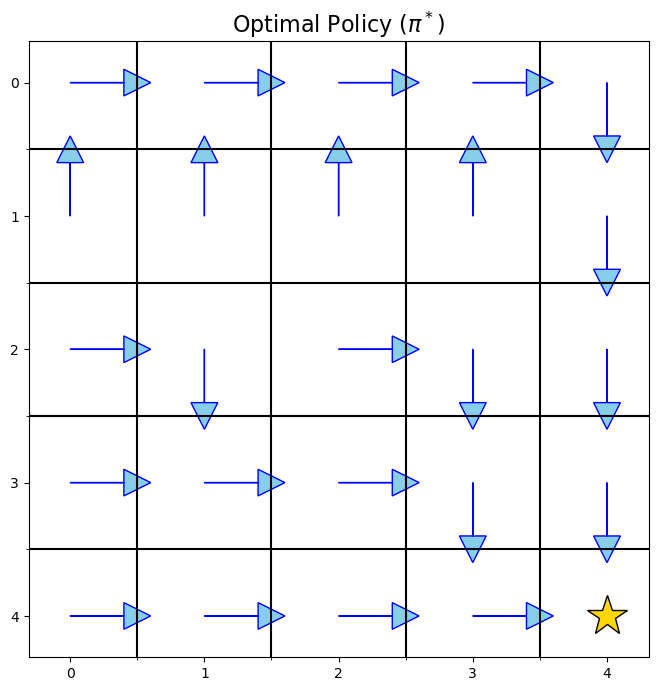

/tmp/ipykernel_20764/2141383075.py:139: SyntaxWarning: invalid escape sequence '\p'
  self._prepare_plot("Optimal Policy ($\pi^*$)")


NameError: name 'NUM_AGents' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import defaultdict
from typing import Tuple, List

# --- Environment Class (Slightly modified to have a simple 'step' method for episodes) ---
class GridWorld:
    """Represents a 5x5 Grid World environment."""
    def __init__(self, size: Tuple[int, int] = (5, 5), terminal_state: Tuple[int, int] = (4, 4)):
        self.rows, self.cols = size
        self.terminal_state = terminal_state
        self.states = [(r, c) for r in range(self.rows) for c in range(self.cols)]
        self.actions = [0, 1, 2, 3] # 0:Up, 1:Down, 2:Left, 3:Right
        self.action_delta = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def get_reward(self, state: Tuple[int, int]) -> int:
        """Returns the reward for being in a given state."""
        return 10 if state == self.terminal_state else -1

    def is_terminal(self, state: Tuple[int, int]) -> bool:
        """Checks if a state is the terminal state."""
        return state == self.terminal_state
    
    def step(self, state: Tuple[int, int], action: int) -> Tuple[Tuple[int, int], int]:
        """Executes one step in the environment for episode generation."""
        if self.is_terminal(state):
            return state, 0
            
        row, col = state
        d_row, d_col = self.action_delta[action]
        next_row, next_col = row + d_row, col + d_col

        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = row, col
            
        next_state = (next_row, next_col)
        reward = self.get_reward(next_state)
        return next_state, reward

# --- New Monte Carlo Solver Class ---
class MonteCarloSolver:
    """
    Solves the GridWorld environment using On-Policy First-Visit Monte Carlo Control.
    """
    def __init__(self, env: GridWorld, gamma: float = 0.9, epsilon: float = 0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        # Q-table stores the value of taking an action 'a' in state 's'
        self.q_table = np.zeros((env.rows, env.cols, len(env.actions)))
        # A dictionary to store lists of returns for each (state, action) pair
        self.returns = defaultdict(list)
        self.policy = np.random.randint(0, 4, size=(env.rows, env.cols))

    def _get_action(self, state: Tuple[int, int]) -> int:
        """Selects an action using an epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.actions)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def _generate_episode(self) -> List[Tuple[Tuple[int, int], int, int]]:
        """Generates one full episode by following the current policy."""
        episode = []
        # Use exploring starts: begin in a random state
        state = (np.random.randint(self.env.rows), np.random.randint(self.env.cols))
        
        while not self.env.is_terminal(state):
            action = self._get_action(state)
            next_state, reward = self.env.step(state, action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def iterate(self, num_episodes: int):
        """
        Performs the Monte Carlo learning process over many episodes.
        """
        for i in range(num_episodes):
            if (i + 1) % 1000 == 0:
                print(f"Running episode {i+1}/{num_episodes}...")
            
            # 1. Generate an episode
            episode = self._generate_episode()
            
            G = 0  # The return (cumulative discounted reward)
            visited_sa_pairs = set()
            
            # 2. Iterate backwards through the episode
            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                G = self.gamma * G + reward
                
                # First-Visit: only update if this is the first time we've seen this (s,a) pair
                if (state, action) not in visited_sa_pairs:
                    self.returns[(state, action)].append(G)
                    # Update the Q-value with the average of all returns seen so far
                    self.q_table[state][action] = np.mean(self.returns[(state, action)])
                    visited_sa_pairs.add((state, action))
        
        print("Monte Carlo learning complete!")

    def get_policy(self) -> np.ndarray:
        """Extracts the greedy policy from the final Q-table."""
        return np.argmax(self.q_table, axis=2)

# --- Visualizer Class (Mostly Unchanged) ---
class GridVisualizer:
    """Handles visualization of the value function, policy, and agent animations."""
    def __init__(self, env: GridWorld):
        self.env = env
        self.fig, self.ax = None, None
    
    def _prepare_plot(self, title: str):
        """Helper to create a standard grid plot."""
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_title(title, fontsize=16)
        self.ax.set_xticks(np.arange(0, self.env.cols, 1))
        self.ax.set_yticks(np.arange(0, self.env.rows, 1))
        self.ax.set_xticks(np.arange(-.5, self.env.cols, 1), minor=True)
        self.ax.set_yticks(np.arange(-.5, self.env.rows, 1), minor=True)
        self.ax.grid(which="minor", color="black", linestyle='-', linewidth=1.5)
        self.ax.invert_yaxis()
        self.ax.plot(self.env.terminal_state[1], self.env.terminal_state[0], '*', color='gold', markersize=30, markeredgecolor='black')

    def plot_value_table(self, value_table: np.ndarray):
        """Visualizes the state-value function (max Q-value) as a heatmap."""
        self._prepare_plot("Optimal Value Function ($V^*$)")
        im = self.ax.imshow(value_table, cmap='viridis')
        self.fig.colorbar(im, ax=self.ax, label="State Value")
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                self.ax.text(c, r, f"{value_table[r, c]:.2f}", ha='center', va='center', color='white' if value_table[r, c] < 2 else 'black')
        plt.show()

    def plot_policy(self, policy: np.ndarray):
        """Visualizes the policy with arrows."""
        self._prepare_plot("Optimal Policy ($\pi^*$)")
        action_arrows = {0: (0, -0.4), 1: (0, 0.4), 2: (-0.4, 0), 3: (0.4, 0)}
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                if not self.env.is_terminal((r, c)):
                    action = policy[r, c]
                    dx, dy = action_arrows[action]
                    self.ax.arrow(c, r, dx, dy, head_width=0.2, head_length=0.2, fc='skyblue', ec='blue')
        plt.show()
    
    def animate_episodes(self, paths: List[List[Tuple[int, int]]]):
        """Animates multiple agents following their paths."""
        self._prepare_plot(f"Multi-Agent Simulation ({len(paths)} Agents)")
        colors = plt.cm.jet(np.linspace(0, 1, len(paths)))
        agent_markers = [self.ax.plot([], [], 'o', color=colors[i], markersize=12)[0] for i in range(len(paths))]
        max_path_len = max(len(p) for p in paths)

        def update(frame):
            for i, marker in enumerate(agent_markers):
                pos_index = min(frame, len(paths[i]) - 1)
                pos = paths[i][pos_index]
                marker.set_data([pos[1]], [pos[0]])
            self.ax.set_title(f"Multi-Agent Simulation | Step: {frame}")
            return agent_markers

        anim = animation.FuncAnimation(self.fig, update, frames=max_path_len, interval=150, blit=True, repeat=False)
        plt.show()

# --- Main Simulation Block ---
if __name__ == "__main__":
    # --- 1. Learning Phase ---
    env = GridWorld()
    # Monte Carlo methods require many episodes to properly explore and converge
    solver = MonteCarloSolver(env, gamma=0.99, epsilon=0.1)
    solver.iterate(num_episodes=10000)
    
    optimal_policy = solver.get_policy()
    # The state-value function V(s) is the value of the best action from that state
    value_table = np.max(solver.q_table, axis=2)

    # --- 2. Visualization of Learning Results ---
    visualizer = GridVisualizer(env)
    visualizer.plot_value_table(value_table)
    visualizer.plot_policy(optimal_policy)

    # --- 3. Execution Phase: Simulate Multiple Agents ---
    NUM_AGENTS = 10
    agent_starts = [(np.random.randint(env.rows), np.random.randint(env.cols)) for _ in range(NUM_AGENTS)]
    all_paths = []

    print(f"\n--- Simulating {NUM_AGents} Agents Following Optimal Policy ---")
    for i, start_pos in enumerate(agent_starts):
        path = [start_pos]
        current_state = start_pos
        
        # Limit steps to prevent infinite loops if policy is suboptimal
        for _ in range(50): 
            if env.is_terminal(current_state):
                break
            action = optimal_policy[current_state]
            # We can use the environment's step function to simulate the final path
            next_state, _ = env.step(current_state, action)
            path.append(next_state)
            current_state = next_state
        
        all_paths.append(path)
        print(f"Agent {i+1} path length: {len(path)-1}")
    
    # Animate all agents moving together
    visualizer.animate_episodes(all_paths)

# Q-Learning

<>:125: SyntaxWarning: invalid escape sequence '\p'
<>:125: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_20764/3248758005.py:125: SyntaxWarning: invalid escape sequence '\p'
  self._prepare_plot("Optimal Policy ($\pi^*$)")


Running episode 1000/10000...
Running episode 2000/10000...
Running episode 3000/10000...
Running episode 4000/10000...
Running episode 5000/10000...
Running episode 6000/10000...
Running episode 7000/10000...
Running episode 8000/10000...
Running episode 9000/10000...
Running episode 10000/10000...
Q-Learning complete!


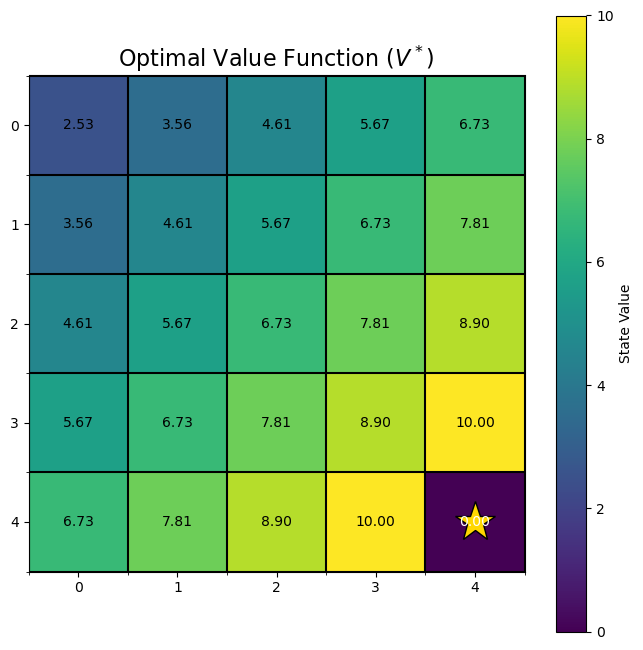

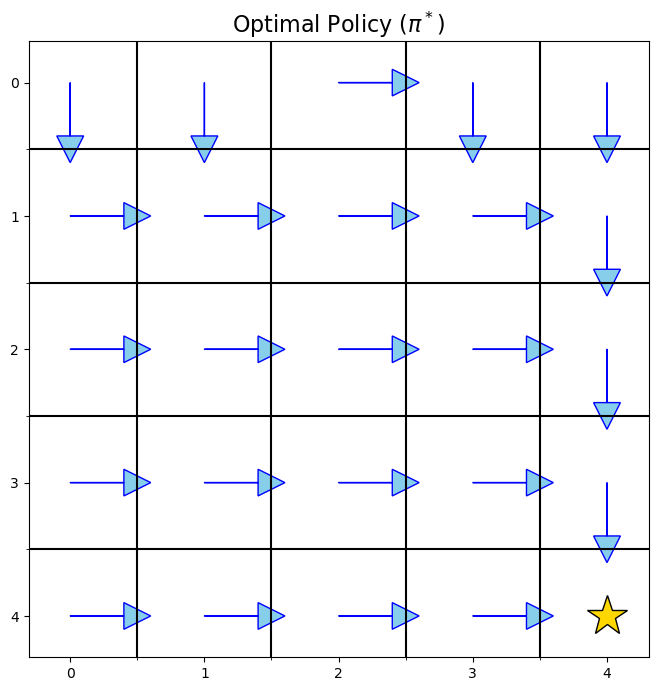


--- Simulating 10 Agents Following Optimal Policy ---
Agent 1 path length: 2
Agent 2 path length: 5
Agent 3 path length: 5
Agent 4 path length: 6
Agent 5 path length: 3
Agent 6 path length: 6
Agent 7 path length: 3
Agent 8 path length: 2
Agent 9 path length: 3
Agent 10 path length: 1


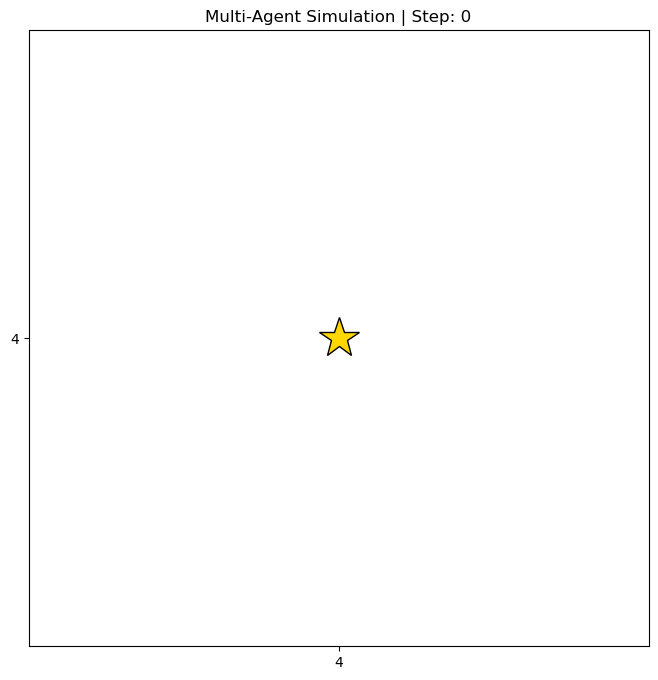

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from typing import Tuple, List

# --- Environment Class (Unchanged) ---
class GridWorld:
    """Represents a 5x5 Grid World environment."""
    def __init__(self, size: Tuple[int, int] = (5, 5), terminal_state: Tuple[int, int] = (4, 4)):
        self.rows, self.cols = size
        self.terminal_state = terminal_state
        self.actions = [0, 1, 2, 3] # 0:Up, 1:Down, 2:Left, 3:Right
        self.action_delta = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def get_reward(self, state: Tuple[int, int]) -> int:
        return 10 if state == self.terminal_state else -1

    def is_terminal(self, state: Tuple[int, int]) -> bool:
        return state == self.terminal_state
    
    def step(self, state: Tuple[int, int], action: int) -> Tuple[Tuple[int, int], int]:
        """Executes one step in the environment."""
        if self.is_terminal(state):
            return state, 0
            
        row, col = state
        d_row, d_col = self.action_delta[action]
        next_row, next_col = row + d_row, col + d_col

        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = row, col
            
        next_state = (next_row, next_col)
        reward = self.get_reward(next_state)
        return next_state, reward
    
    def reset(self) -> Tuple[int, int]:
        """Resets the environment to a random start state."""
        return (np.random.randint(self.rows), np.random.randint(self.cols))

# --- New Q-Learning Solver Class ---
class QLearningSolver:
    """
    Solves the GridWorld environment using the Q-Learning algorithm.
    """
    def __init__(self, env: GridWorld, alpha: float, gamma: float, epsilon: float):
        self.env = env
        self.alpha = alpha       # Learning rate
        self.gamma = gamma       # Discount factor
        self.epsilon = epsilon   # Exploration rate
        self.q_table = np.zeros((env.rows, env.cols, len(env.actions)))

    def _get_action(self, state: Tuple[int, int]) -> int:
        """Selects an action using an epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.actions)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def iterate(self, num_episodes: int):
        """
        Performs the Q-Learning algorithm over many episodes.
        """
        for i in range(num_episodes):
            if (i + 1) % 1000 == 0:
                print(f"Running episode {i+1}/{num_episodes}...")
            
            state = self.env.reset()
            
            done = False
            while not done:
                # 1. Choose action using epsilon-greedy policy
                action = self._get_action(state)
                
                # 2. Take action and observe outcome
                next_state, reward = self.env.step(state, action)
                
                # 3. Perform the Q-Learning update
                old_value = self.q_table[state][action]
                next_max = np.max(self.q_table[next_state]) # Greedy choice for next state
                
                # The core Q-Learning update rule
                target = reward + self.gamma * next_max
                new_value = old_value + self.alpha * (target - old_value)
                self.q_table[state][action] = new_value
                
                # 4. Move to the next state
                state = next_state
                done = self.env.is_terminal(state)
        
        print("Q-Learning complete!")

    def get_policy(self) -> np.ndarray:
        """Extracts the greedy policy from the final Q-table."""
        return np.argmax(self.q_table, axis=2)

# --- Visualizer Class (Unchanged) ---
class GridVisualizer:
    """Handles visualization of the value function, policy, and agent animations."""
    def __init__(self, env: GridWorld):
        self.env = env
        self.fig, self.ax = None, None
    
    def _prepare_plot(self, title: str):
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_title(title, fontsize=16)
        self.ax.set_xticks(np.arange(0, self.env.cols, 1))
        self.ax.set_yticks(np.arange(0, self.env.rows, 1))
        self.ax.set_xticks(np.arange(-.5, self.env.cols, 1), minor=True)
        self.ax.set_yticks(np.arange(-.5, self.env.rows, 1), minor=True)
        self.ax.grid(which="minor", color="black", linestyle='-', linewidth=1.5)
        self.ax.invert_yaxis()
        self.ax.plot(self.env.terminal_state[1], self.env.terminal_state[0], '*', color='gold', markersize=30, markeredgecolor='black')

    def plot_value_table(self, value_table: np.ndarray):
        self._prepare_plot("Optimal Value Function ($V^*$)")
        im = self.ax.imshow(value_table, cmap='viridis')
        self.fig.colorbar(im, ax=self.ax, label="State Value")
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                self.ax.text(c, r, f"{value_table[r, c]:.2f}", ha='center', va='center', color='white' if value_table[r, c] < 2 else 'black')
        plt.show()

    def plot_policy(self, policy: np.ndarray):
        self._prepare_plot("Optimal Policy ($\pi^*$)")
        action_arrows = {0: (0, -0.4), 1: (0, 0.4), 2: (-0.4, 0), 3: (0.4, 0)}
        for r in range(self.env.rows):
            for c in range(self.env.cols):
                if not self.env.is_terminal((r, c)):
                    action = policy[r, c]
                    dx, dy = action_arrows[action]
                    self.ax.arrow(c, r, dx, dy, head_width=0.2, head_length=0.2, fc='skyblue', ec='blue')
        plt.show()
    
    def animate_episodes(self, paths: List[List[Tuple[int, int]]]):
        self._prepare_plot(f"Multi-Agent Simulation ({len(paths)} Agents)")
        colors = plt.cm.jet(np.linspace(0, 1, len(paths)))
        agent_markers = [self.ax.plot([], [], 'o', color=colors[i], markersize=12)[0] for i in range(len(paths))]
        max_path_len = max(len(p) for p in paths)

        def update(frame):
            for i, marker in enumerate(agent_markers):
                pos_index = min(frame, len(paths[i]) - 1)
                pos = paths[i][pos_index]
                marker.set_data([pos[1]], [pos[0]])
            self.ax.set_title(f"Multi-Agent Simulation | Step: {frame}")
            return agent_markers

        anim = animation.FuncAnimation(self.fig, update, frames=max_path_len, interval=150, blit=True, repeat=False)
        plt.show()

# --- Main Simulation Block ---
if __name__ == "__main__":
    # --- 1. Learning Phase ---
    env = GridWorld()
    
    # Hyperparameters
    ALPHA = 0.1      # Learning Rate
    GAMMA = 0.99     # Discount Factor
    EPSILON = 0.1    # Exploration Rate
    NUM_EPISODES = 10000

    solver = QLearningSolver(env, alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON)
    solver.iterate(num_episodes=NUM_EPISODES)
    
    optimal_policy = solver.get_policy()
    # The state-value function V(s) is the value of the best action from that state
    value_table = np.max(solver.q_table, axis=2)

    # --- 2. Visualization of Learning Results ---
    visualizer = GridVisualizer(env)
    visualizer.plot_value_table(value_table)
    visualizer.plot_policy(optimal_policy)

    # --- 3. Execution Phase: Simulate Multiple Agents ---
    NUM_AGENTS = 10
    agent_starts = [env.reset() for _ in range(NUM_AGENTS)]
    all_paths = []

    print(f"\n--- Simulating {NUM_AGENTS} Agents Following Optimal Policy ---")
    for i, start_pos in enumerate(agent_starts):
        path = [start_pos]
        current_state = start_pos
        
        # Limit steps to prevent infinite loops
        for _ in range(50): 
            if env.is_terminal(current_state):
                break
            action = optimal_policy[current_state]
            next_state, _ = env.step(current_state, action)
            path.append(next_state)
            current_state = next_state
        
        all_paths.append(path)
        print(f"Agent {i+1} path length: {len(path)-1}")
    
    # Animate all agents moving together
    visualizer.animate_episodes(all_paths)